# Let's begin

In [1]:
#import tools for twitter API
import tweepy
from twitter import *
import pymongo, pprint
from pymongo import MongoClient
#Import everything useful for networks
import networkx as nx
import matplotlib.pyplot as plt
import json
import time
import datetime
import os
import pickle
import elections_helper as helper

### Twitter APIs

In [2]:
properties = dict(line.strip().split('=') 
          for line in open('./properties/elections.properties') 
          if not line.startswith('#') and not line.startswith('\n'))

In [3]:
CONSUMER_KEY = 'aF03g35xEjOm5OQuFw8PSuwLF'
CONSUMER_SECRET ='5Ifz6t0UPa6BxaaVm7eTQF4cOe3XcpVsX535nFkaLqy5bp7ehg'
OAUTH_TOKEN = '594338908-f0JBTAwwVGoZErJ4f1YNAgkj2gws7FQaFur4r2gs'
OAUTH_TOKEN_SECRET = 'EOR9ptKEtAc0LyhsEOAxsyEshWdgTcJKzXS6iBln2iB6h'

In [4]:
# load our API credentials 
twitter = Twitter(
    auth = OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET, CONSUMER_KEY, CONSUMER_SECRET))

In [5]:
#Credentials for tweepy (use it as complement)
auth = tweepy.OAuthHandler(properties["CONSUMER_KEY"], properties["CONSUMER_SECRET"])
auth.set_access_token(properties["OAUTH_TOKEN"], properties["OAUTH_TOKEN_SECRET"])
api = tweepy.API(auth)

### Get the users from Mongo DB

For more efficiency we used Mongo data base to store all of our datas so they are available by anyone at anytime.

In [6]:
# Connect to MongoDB
client = helper.setup_mongo_client(properties_file='./properties/db.properties')

_, user_collection = helper.get_collections(client)

print "Number of users %s" % user_collection.count()

Number of users 87501


### Create the network

Now that everything is settled we can start working on our tweet. 

In [7]:
# Create a list of user_ids
all_user_ids = {}
for user in user_collection.find():
    all_user_ids[user['_id']] = []
print "Number of users %s" % len(all_user_ids)

Number of users 87501


In [ ]:
# Create the graph
directed = nx.DiGraph()

# All twitter users in the database
users = user_collection.find()

for i in users:
    
    _id = i["_id"]
    # We need to deal with the rate limit of twitter API
    # It's not the best way but it works and we don't really need more
    try:
        #select the user name
        user = api.get_user(_id)
        username = user.screen_name

        # perform a basic search 
        query = twitter.friends.ids(screen_name = username)
                
        found_ids = [user_id for user_id in query["ids"] if all_user_ids.get(user_id, 0) != 0]

        print "found %d friends but only %s tweeted about the election" % (len(query["ids"]),len(found_ids))
        
        if len(found_ids) == 0:
            continue
            
        # now we loop through them to pull out more info, in blocks of 100.
        for n in range(0, len(found_ids), 100):
            ids = found_ids[n:n+100]
            
            # create a subquery, looking up information about these users
            subquery = twitter.users.lookup(user_id = ids)

            for user_q in subquery:
                # now print out user info, starring any users that are Verified.
                directed.add_node(user_q["screen_name"])
                directed.add_edge(username, user_q["screen_name"])
                #print " [%s] %s" % ("*" if user["verified"] else " ", user["screen_name"])
    except Exception as e:
        #Sleep while we cannot access twitter
        print "Rate Limit Error: %s" % e
        time.sleep(15 * 60 + 15)
        continue

Rate Limit Error: Twitter sent status 429 for URL: 1.1/friends/ids.json using parameters: (oauth_consumer_key=aF03g35xEjOm5OQuFw8PSuwLF&oauth_nonce=10815134659641301651&oauth_signature_method=HMAC-SHA1&oauth_timestamp=1481034902&oauth_token=594338908-f0JBTAwwVGoZErJ4f1YNAgkj2gws7FQaFur4r2gs&oauth_version=1.0&screen_name=Sttephy&oauth_signature=hDQh%2FV3B2sh1BrqgNSVnwtjFHT4%3D)
details: {u'errors': [{u'message': u'Rate limit exceeded', u'code': 88}]}


In [35]:
user_ids

{790262350150369280L: [],
 756310591422201856L: [],
 758745929797074946L: [],
 705794670454898691L: [],
 786508282588299268L: [],
 784761251150692357L: [],
 17563655: [],
 758999979172036610L: [],
 308281360: [],
 438829074: [],
 717718782752325635L: [],
 764643707115012100L: [],
 714247028134379525L: [],
 11796512: [],
 807141409: [],
 46892407: [],
 1447034917: [],
 345811633: [],
 206045226: [],
 707788010398547975L: [],
 1149501486: [],
 4665901105L: [],
 464519220: [],
 165412919: [],
 16252985: [],
 16252989: [],
 767012827064332289L: [],
 618397761: [],
 19660866: [],
 239075395: [],
 24379461: [],
 491476321: [],
 77638328: [],
 131072082: [],
 275251285: [],
 390332502: [],
 1445986392: [],
 18612314: [],
 599261276: [],
 369885278: [],
 150208608: [],
 315097104: [],
 70778978: [],
 792738061373345792L: [],
 892338276: [],
 613679206: [],
 337117291: [],
 6815762: [],
 2798125167L: [],
 29360240: [],
 1697644657: [],
 2889351286L: [],
 264503416: [],
 109576316: [],
 31195262

In [29]:
user_ids[75541946]

[]

** Draw is way too expensive, we have to do some work on the graph before. But first we save the network as a txt file so we won't have to run the code again **

In [ ]:
import pickle
#Saving the network
pickle.dump(directed, open('graph2.txt', 'w'))

In [66]:
#Open the network
dire = pickle.load(open('./graph2.txt'))

## Basic Stats

In [128]:
import numpy as np
%matplotlib inline 

In [32]:
#Number of node
print "The graph has %d nodes" % directed.number_of_nodes() , "and and %d edges "% directed.number_of_edges()


#Top 10 account by in and out degree
node_in_degree_tuples = sorted([(node, directed.in_degree(node)) for node in directed.nodes()], key=lambda (n, d): -d)
node_out_degree_tuples = sorted([(node, directed.out_degree(node)) for node in directed.nodes()], key=lambda (n, d): -d)

print node_in_degree_tuples[:10]
print node_out_degree_tuples[:10]




The graph has 64728 nodes and and 78788 edges 
[(u'wikileaks', 30), (u'realDonaldTrump', 27), (u'BarackObama', 27), (u'POTUS', 24), (u'HillaryClinton', 24), (u'BernieSanders', 23), (u'KellyannePolls', 22), (u'mike_pence', 22), (u'DRUDGE_REPORT', 21), (u'RealBenCarson', 21)]
[(u'sallykohn', 4736), (u'ladygaga', 4557), (u'wikileaks', 4527), (u'StevenTDennis', 4507), (u'stuartpstevens', 4399), (u'Shottyisms', 3415), (u'bad_bad_bernie', 2986), (u'CaptainsLog2016', 2906), (u'SanFranMoman', 2692), (u'Trevor90666770', 2541)]


* The following section draws the distribution graphs.

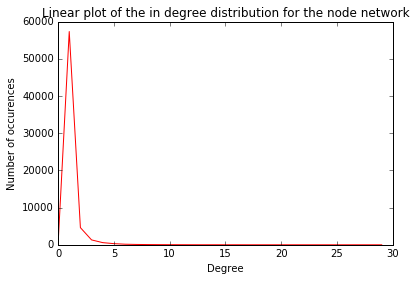

In [26]:
#Distributions
# Compute min and max values for the degrees
node_in_degree = map(lambda x: x[1], node_in_degree_tuples)
node_out_degree = map(lambda x: x[1], node_out_degree_tuples)
max_in_degree = max(node_in_degree)
min_in_degree = min(node_in_degree)
max_out_degree = max(node_out_degree)
min_out_degree = min(node_out_degree)

# Compute the bins for our degree distribution
bins_in = [i for i in range(min_in_degree, max_in_degree+1)]
bins_out = [i for i in range(min_out_degree, max_out_degree+1)]

degrees_in_hist, degrees_in_bin = np.histogram(node_in_degree, bins=bins_in)
degrees_out_hist, degrees_out_bin = np.histogram(node_out_degree, bins=bins_out)

plt.plot(degrees_in_bin[:-1], degrees_in_hist, 'r')
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Linear plot of the in degree distribution for the node network')
plt.show()

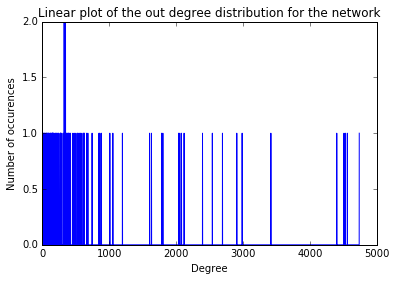

In [38]:
plt.plot(degrees_out_bin[:-1], degrees_out_hist, 'b')
plt.axis([0, 5000, 0, 2])
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Linear plot of the out degree distribution for the network')
plt.show()

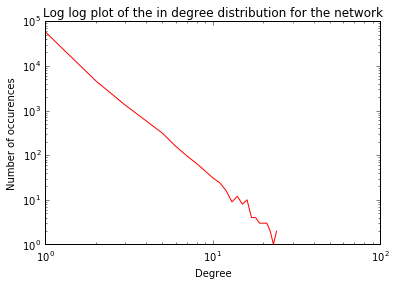

In [39]:
plt.loglog(degrees_in_bin[:-1], degrees_in_hist, 'r')
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Log log plot of the in degree distribution for the network')
plt.show()

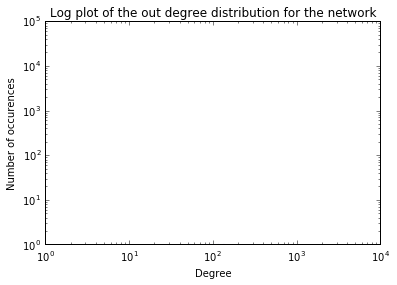

In [42]:


plt.loglog(degrees_out_bin[:-1], degrees_out_hist)
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Log plot of the out degree distribution for the network')
plt.show()



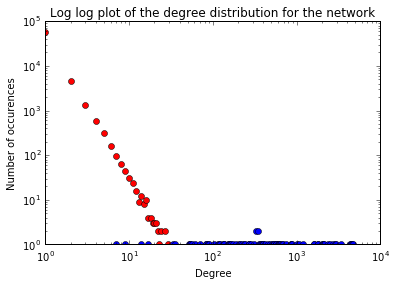

In [30]:
plt.loglog(degrees_in_bin[:-1], degrees_in_hist, 'ro')
plt.loglog(degrees_out_bin[:-1], degrees_out_hist, 'o')
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Log log plot of the degree distribution for the network')
plt.show()

## Centrality and other stuffs

* The following section draws the graph and weigth the size of a node according to its degree. The plot itself is not really important, but it looks cool !

The graph is way too big to be drawn, so we decide to make a smaller graph. The idea is to keep the node with a degree greater than 3 only. We have a lot of isolated accounts that are quite useless in this centrality analysis.

In [67]:
#Compute a list of nodes with a degree < 1 to remove
to_remove = [node for node,degree in dire.degree().items() if degree < 3]

In [68]:
# We make a copy of the original graph
test = dire.copy()

In [69]:
#We remove the nodes
test.remove_nodes_from(to_remove)

In [101]:
#Number of node
print "The graph has now %d nodes" % test.number_of_nodes() , "and and %d edges "% test.number_of_edges()


#Top 10 account by in and out degree
node_in_degree_tuples = sorted([(node, test.in_degree(node)) for node in test.nodes()], key=lambda (n, d): -d)
node_out_degree_tuples = sorted([(node, test.out_degree(node)) for node in test.nodes()], key=lambda (n, d): -d)
print "The top ten accounts by in degree are : "
print node_in_degree_tuples[:10]
print "The top ten accounts by out degree are : "
print node_out_degree_tuples[:10]

The graph has now 2785 nodes and and 12228 edges 
The top ten accounts by in degree are : 
[(u'wikileaks', 30), (u'realDonaldTrump', 27), (u'BarackObama', 27), (u'POTUS', 24), (u'HillaryClinton', 24), (u'BernieSanders', 23), (u'mike_pence', 22), (u'KellyannePolls', 22), (u'DRUDGE_REPORT', 21), (u'RealBenCarson', 21)]
The top ten accounts by out degree are : 
[(u'sallykohn', 885), (u'StevenTDennis', 777), (u'stuartpstevens', 733), (u'Trevor90666770', 726), (u'sanchezcan', 724), (u'kurteichenwald', 655), (u'PPolenberg', 439), (u'halsteadg048', 405), (u'jojoh888', 351), (u'bad_bad_bernie', 317)]


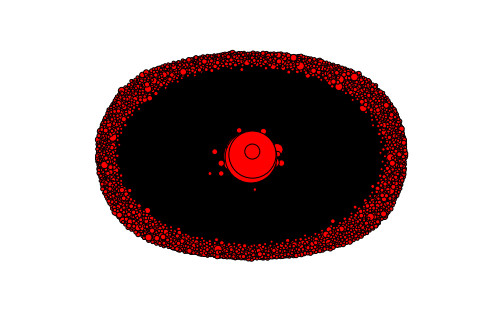

In [78]:
#We can now plot the network 
d = nx.degree(test)
nx.draw(test, nodelist=d.keys(), node_size=[v * 3 for v in d.values()])
plt.show()

In [79]:
plt.savefig("graph.pdf")

* We will now go through some centrality measures. We perform these algorithms on the reduced network as these measures are very costly 

In [70]:
# We need an undirectd graph
undir = test.to_undirected()

In [81]:
#Betweeness centrality
between_centrality = nx.betweenness_centrality(undir)
between_centrality_sorted = sorted(between_centrality.iteritems(), key=lambda (name, value): -value)

print "Betweenes : The 5 most central accounts are :\n" 
print between_centrality_sorted[:5]

Betweenes : The 5 most central accounts are :

[(u'Trevor90666770', 0.19344522557156732), (u'sallykohn', 0.17619084394519682), (u'stuartpstevens', 0.14708972224880318), (u'StevenTDennis', 0.13828282353275367), (u'sanchezcan', 0.12851328806855555)]


In [83]:
#Eigen vectore centrality
eigen_centrality = nx.eigenvector_centrality(undir)
eigen_centrality_sorted = sorted(eigen_centrality.iteritems(), key=lambda (name, value): -value)

print "Eigen : The 5 most central accounts are :\n" 
print eigen_centrality_sorted[:5]

Eigen : The 5 most central accounts are :

[(u'sallykohn', 0.3055201383264885), (u'sanchezcan', 0.27596570515958063), (u'StevenTDennis', 0.27116859006756233), (u'stuartpstevens', 0.264643703632886), (u'kurteichenwald', 0.2609156928239351)]


In [85]:
#In degree centrality
in_centrality = nx.in_degree_centrality(test)
in_centrality_sorted = sorted(in_centrality.iteritems(), key=lambda (name, value): -value)

print "In degree centrality : The 5 most central accounts are :\n" 
print in_centrality_sorted[:5]

In degree centrality : The 5 most central accounts are :

[(u'wikileaks', 0.010775862068965518), (u'realDonaldTrump', 0.009698275862068966), (u'BarackObama', 0.009698275862068966), (u'POTUS', 0.008620689655172414), (u'HillaryClinton', 0.008620689655172414)]


In [86]:
#out degree centrality
out_centrality = nx.out_degree_centrality(test)
out_centrality_sorted = sorted(out_centrality.iteritems(), key=lambda (name, value): -value)

print "out degree centrality : The 5 most central accounts are :\n" 
print out_centrality_sorted[:5]

out degree centrality : The 5 most central accounts are :

[(u'sallykohn', 0.31788793103448276), (u'StevenTDennis', 0.2790948275862069), (u'stuartpstevens', 0.26329022988505746), (u'Trevor90666770', 0.2607758620689655), (u'sanchezcan', 0.2600574712643678)]


In [94]:
#Now we want to check if there is a path between Clinton and Trump on both networks
print nx.has_path(undir, u'HillaryClinton',  u'realDonaldTrump')
print nx.has_path(test, u'HillaryClinton',  u'realDonaldTrump')

True
False


In [99]:
print nx.shortest_path_length(undir, u'HillaryClinton',  u'realDonaldTrump')
print nx.shortest_path_length(undir, u'HillaryClinton',  u'wikileaks')
print nx.shortest_path_length(undir, u'BarackObama',  u'realDonaldTrump')

2
2
2


## Problem importing community 

## Community detection

In [254]:
import community

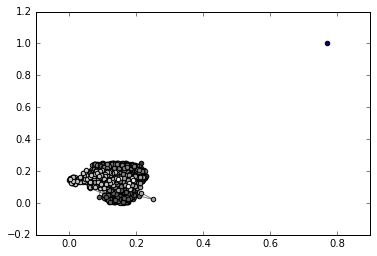

In [218]:
partition = best_partition(undir)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(undir)
count = 0.5
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(undir, pos, list_nodes, node_size = 20,
                                node_color = str(count / (size)))


nx.draw_networkx_edges(undir,pos, alpha=0.5)
plt.show()

In [111]:
louvain_modularity = modularity(partition, undir)
louvain_modularity

0.4032080138771301

* We got a louvain modularity of 0.4, we can say this modularity is pretty high, which means we have good partitions in our network.


In [153]:
communities = {}

# Create a dictionary of all communities and their associated user 
for user, community_index in partition.iteritems():
    if community_index in communities:
        communities[community_index].add(user)
    else:
        communities[community_index] = {user}
    
nb_communities = len(communities)
nb_communities

7

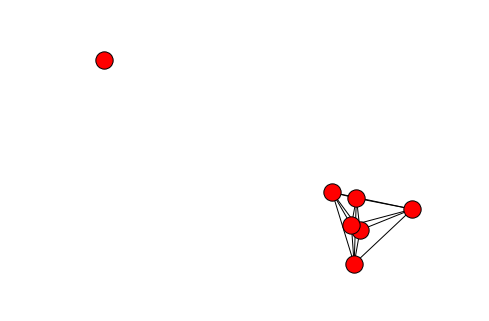

In [129]:
ind = induced_graph(partition, undir)
nx.draw(ind)
plt.show()

* Our network has 7 different communities according to the louvain algorithm

In [220]:
com= [communities.values()[0],
    communities.values()[1],
    communities.values()[2],
    communities.values()[3],
    communities.values()[4],
    communities.values()[5],
    communities.values()[6],
]

In [253]:
#Top 10 account by in and out degree
for i in range (0,7):
    node = com[i]
    sub = test.subgraph(node)
    node_in_degree_tuples = sorted([(node, sub.in_degree(node)) for node in sub.nodes()], key=lambda (n, d): -d)
    node_out_degree_tuples = sorted([(node, sub.out_degree(node)) for node in sub.nodes()], key=lambda (n, d): -d)
    print("In community ", i)
    print("The top ten accounts by in degree are : ")
    print( node_in_degree_tuples[:10])
    print("The top ten accounts by out degree are : ")
    print( node_out_degree_tuples[:10])
    print("\n")

In community  0
The top ten accounts by in degree are : 
[(u'NASA', 10), (u'wikileaks', 9), (u'BillGates', 9), (u'washingtonpost', 9), (u'AP', 9), (u'BernieSanders', 8), (u'BBCBreaking', 8), (u'nytimes', 8), (u'guardian', 7), (u'TIME', 7)]
The top ten accounts by out degree are : 
[(u'PPolenberg', 238), (u'wikileaks', 138), (u'GreenPartyUS', 137), (u'jkoking', 93), (u'macdoodled', 82), (u'sulaimanslalani', 81), (u'Independent', 75), (u'JesseBenn', 70), (u'ajplus', 68), (u'AinDC', 58)]


In community  1
The top ten accounts by in degree are : 
[(u'JudgeJeanine', 17), (u'seanhannity', 17), (u'mike_pence', 16), (u'SheriffClarke', 15), (u'RealBenCarson', 15), (u'LouDobbs', 14), (u'DonaldJTrumpJr', 14), (u'IngrahamAngle', 14), (u'DRUDGE_REPORT', 13), (u'DineshDSouza', 13)]
The top ten accounts by out degree are : 
[(u'Trevor90666770', 508), (u'halsteadg048', 376), (u'jojoh888', 344), (u'shabeau2', 231), (u'An_Investigator', 177), (u'Sunshine420too', 132), (u'FoxNews', 112), (u'katzkab11', 7